# 1.23c: Cloud Motion Explorer

**Goal:** Understand how the dead token cloud moves as a whole during Flannel training.

We've been assuming the cloud expands radially from the origin like a balloon inflating. But is that actually true? This notebook explores the bulk motion of the cloud without assuming any particular mechanism.

**Key questions:**
- Does the centroid of the cloud drift over time?
- How does centroid motion relate to cloud dispersion?
- Is the motion primarily radial expansion, directional drift, or both?
- How does cloud shape evolve?
- What does the velocity field look like?

**Data:** Flannel 4, run 0 (seed 42) — single representative trajectory for initial exploration.

## Parameters

In [38]:
from pathlib import Path

# Paths
TENSOR_DIR = Path('../tensors/Flannel')
DATA_PATH = TENSOR_DIR / '1.20d_flannel_4.safetensors'
MASK_PATH = TENSOR_DIR / 'live_dead_tokens.safetensors'

# Analysis parameters
RUN_IDX = 0  # Use first run (seed 42) for exploration
RANDOM_SEED = 42

# Visualization
DPI = 200
FIGSIZE = (12, 4)

## Imports

In [39]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from safetensors.torch import load_file

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("Imports complete")

Imports complete


## Load Data

In [40]:
# Load Flannel 4 data
print(f"Loading: {DATA_PATH}")
data = load_file(DATA_PATH)

# Full embedding matrix: (10 runs, 1001 timesteps, 10000 tokens, 64 dims)
W_full = data['W']
print(f"  Full W shape: {tuple(W_full.shape)}")

# Load token mask
print(f"\nLoading: {MASK_PATH}")
mask_data = load_file(MASK_PATH)
dead_mask = mask_data['dead_mask'].bool()
n_dead = dead_mask.sum().item()
n_live = (~dead_mask).sum().item()
print(f"  Live tokens: {n_live:,}")
print(f"  Dead tokens: {n_dead:,}")

Loading: ../tensors/Flannel/1.20d_flannel_4.safetensors
  Full W shape: (10, 1001, 10000, 64)

Loading: ../tensors/Flannel/live_dead_tokens.safetensors
  Live tokens: 6,301
  Dead tokens: 3,699


In [41]:
# Extract single run, dead tokens only
# Shape: (1001, 3699, 64)
W_dead = W_full[RUN_IDX, :, dead_mask, :].float()

n_steps, n_tokens, n_dims = W_dead.shape
print(f"Dead token embeddings: {n_steps} timesteps, {n_tokens} tokens, {n_dims} dimensions")
print(f"Memory: {W_dead.element_size() * W_dead.nelement() / 1024**2:.1f} MB")

Dead token embeddings: 1001 timesteps, 3699 tokens, 64 dimensions
Memory: 904.0 MB


## Centroid Trajectory

First, let's see where the center of mass of the cloud goes over time.

In [42]:
# Compute centroid at each timestep
# Shape: (1001, 64)
centroids = W_dead.mean(dim=1)

# Distance of centroid from origin over time
centroid_norms = torch.norm(centroids, dim=1)

print(f"Centroid at t=0: norm = {centroid_norms[0]:.6f}")
print(f"Centroid at t=1000: norm = {centroid_norms[-1]:.6f}")
print(f"Total drift: {centroid_norms[-1] - centroid_norms[0]:.6f} units")

Centroid at t=0: norm = 0.002689
Centroid at t=1000: norm = 0.500136
Total drift: 0.497447 units


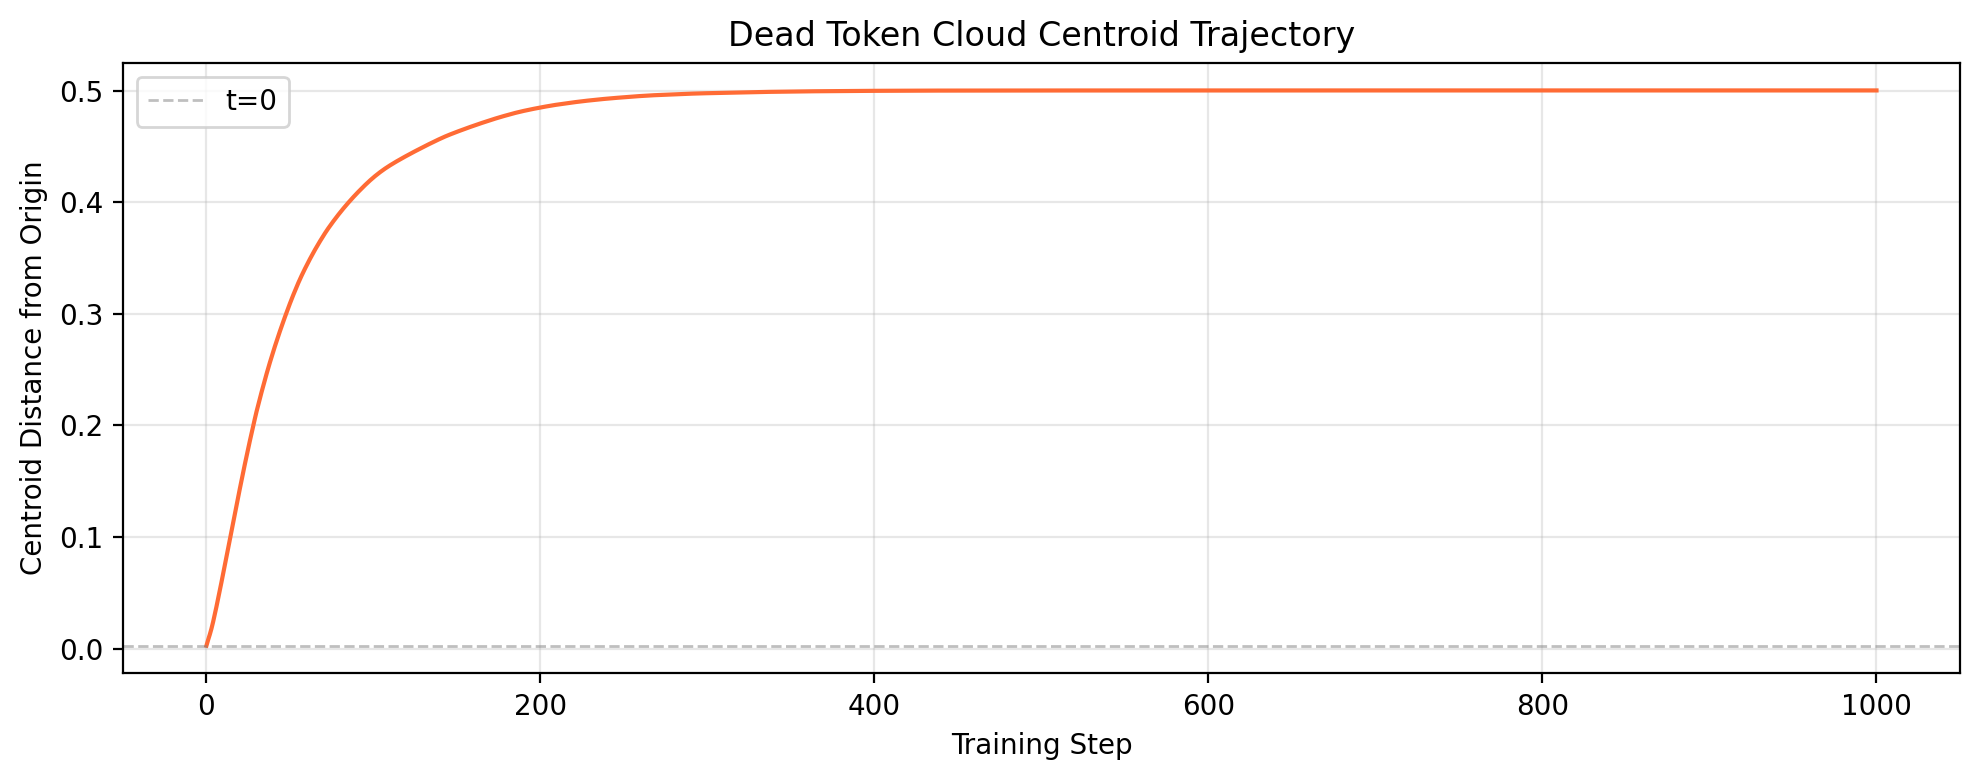

In [43]:
# Plot centroid distance from origin over time
fig, ax = plt.subplots(figsize=(10, 4), dpi=DPI)

ax.plot(centroid_norms.numpy(), linewidth=1.5, color='#FF6B35')
ax.axhline(centroid_norms[0].item(), color='gray', linestyle='--', linewidth=1, alpha=0.5, label='t=0')

ax.set_xlabel('Training Step')
ax.set_ylabel('Centroid Distance from Origin')
ax.set_title('Dead Token Cloud Centroid Trajectory')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## Cloud Dispersion

Now let's see how spread out the tokens are around the centroid.

In [44]:
# For each timestep, compute mean distance from tokens to centroid
# This is the "radius" of the cloud measured from its center of mass
dispersions = torch.zeros(n_steps)

for t in range(n_steps):
    # Distance from each token to centroid at this timestep
    deviations = W_dead[t] - centroids[t]
    dispersions[t] = torch.norm(deviations, dim=1).mean()

print(f"Dispersion at t=0: {dispersions[0]:.6f}")
print(f"Dispersion at t=1000: {dispersions[-1]:.6f}")
print(f"Expansion factor: {dispersions[-1] / dispersions[0]:.2f}x")

Dispersion at t=0: 0.159301
Dispersion at t=1000: 0.115900
Expansion factor: 0.73x


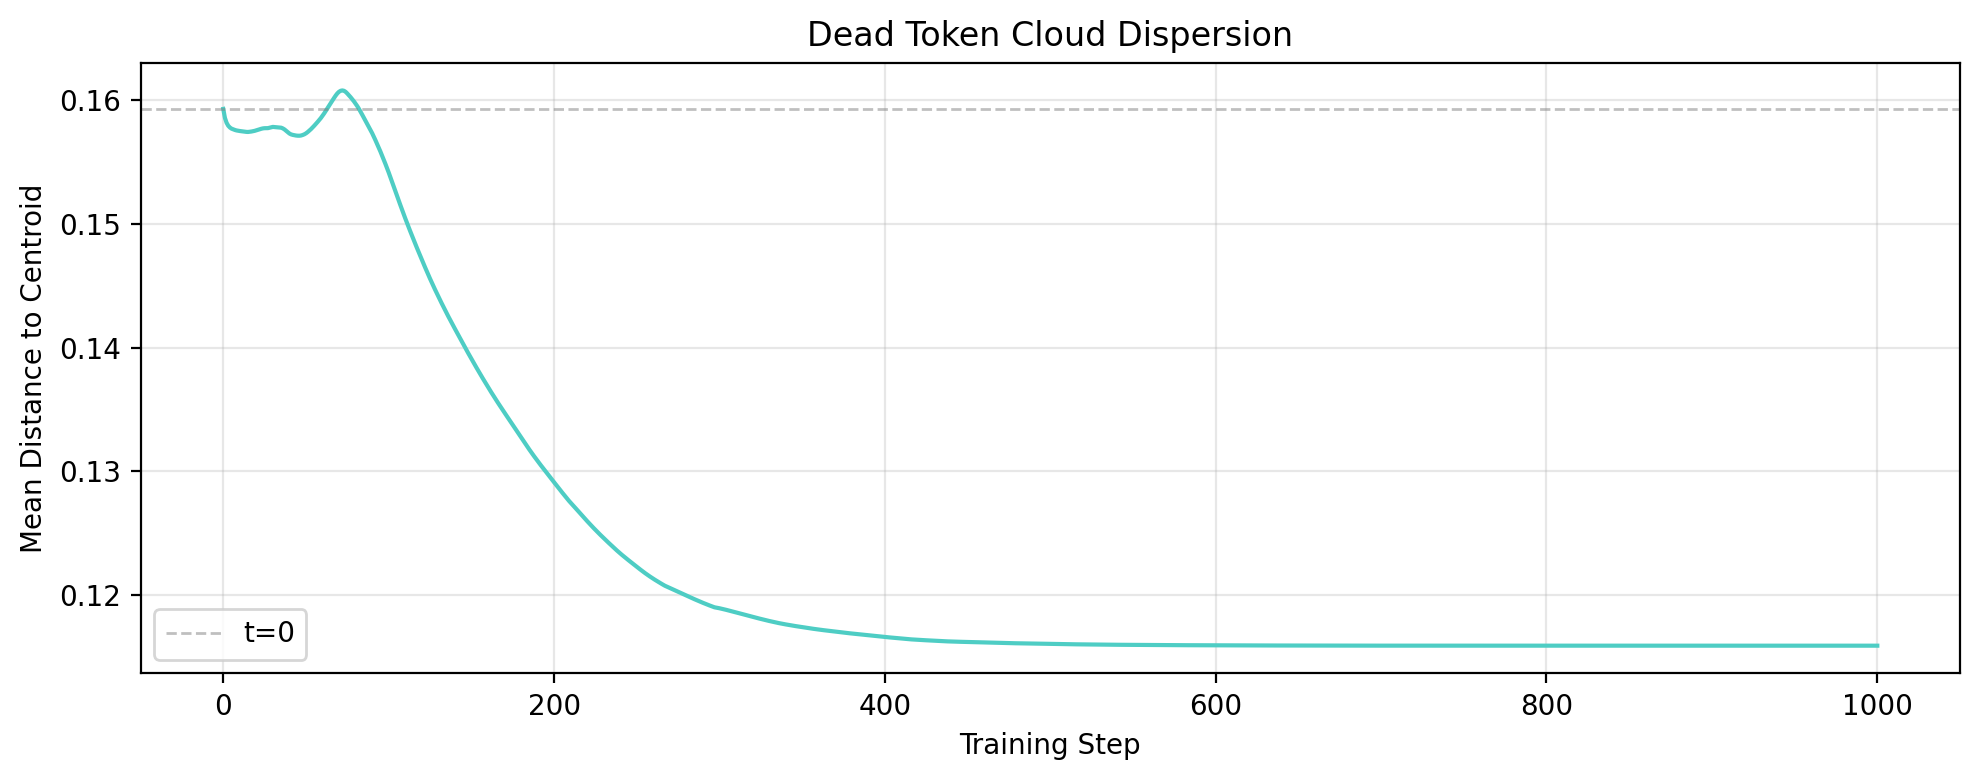

In [45]:
# Plot dispersion over time
fig, ax = plt.subplots(figsize=(10, 4), dpi=DPI)

ax.plot(dispersions.numpy(), linewidth=1.5, color='#4ECDC4')
ax.axhline(dispersions[0].item(), color='gray', linestyle='--', linewidth=1, alpha=0.5, label='t=0')

ax.set_xlabel('Training Step')
ax.set_ylabel('Mean Distance to Centroid')
ax.set_title('Dead Token Cloud Dispersion')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## Centroid vs Dispersion

How do these two motions relate? Is centroid drift driving dispersion, or vice versa?

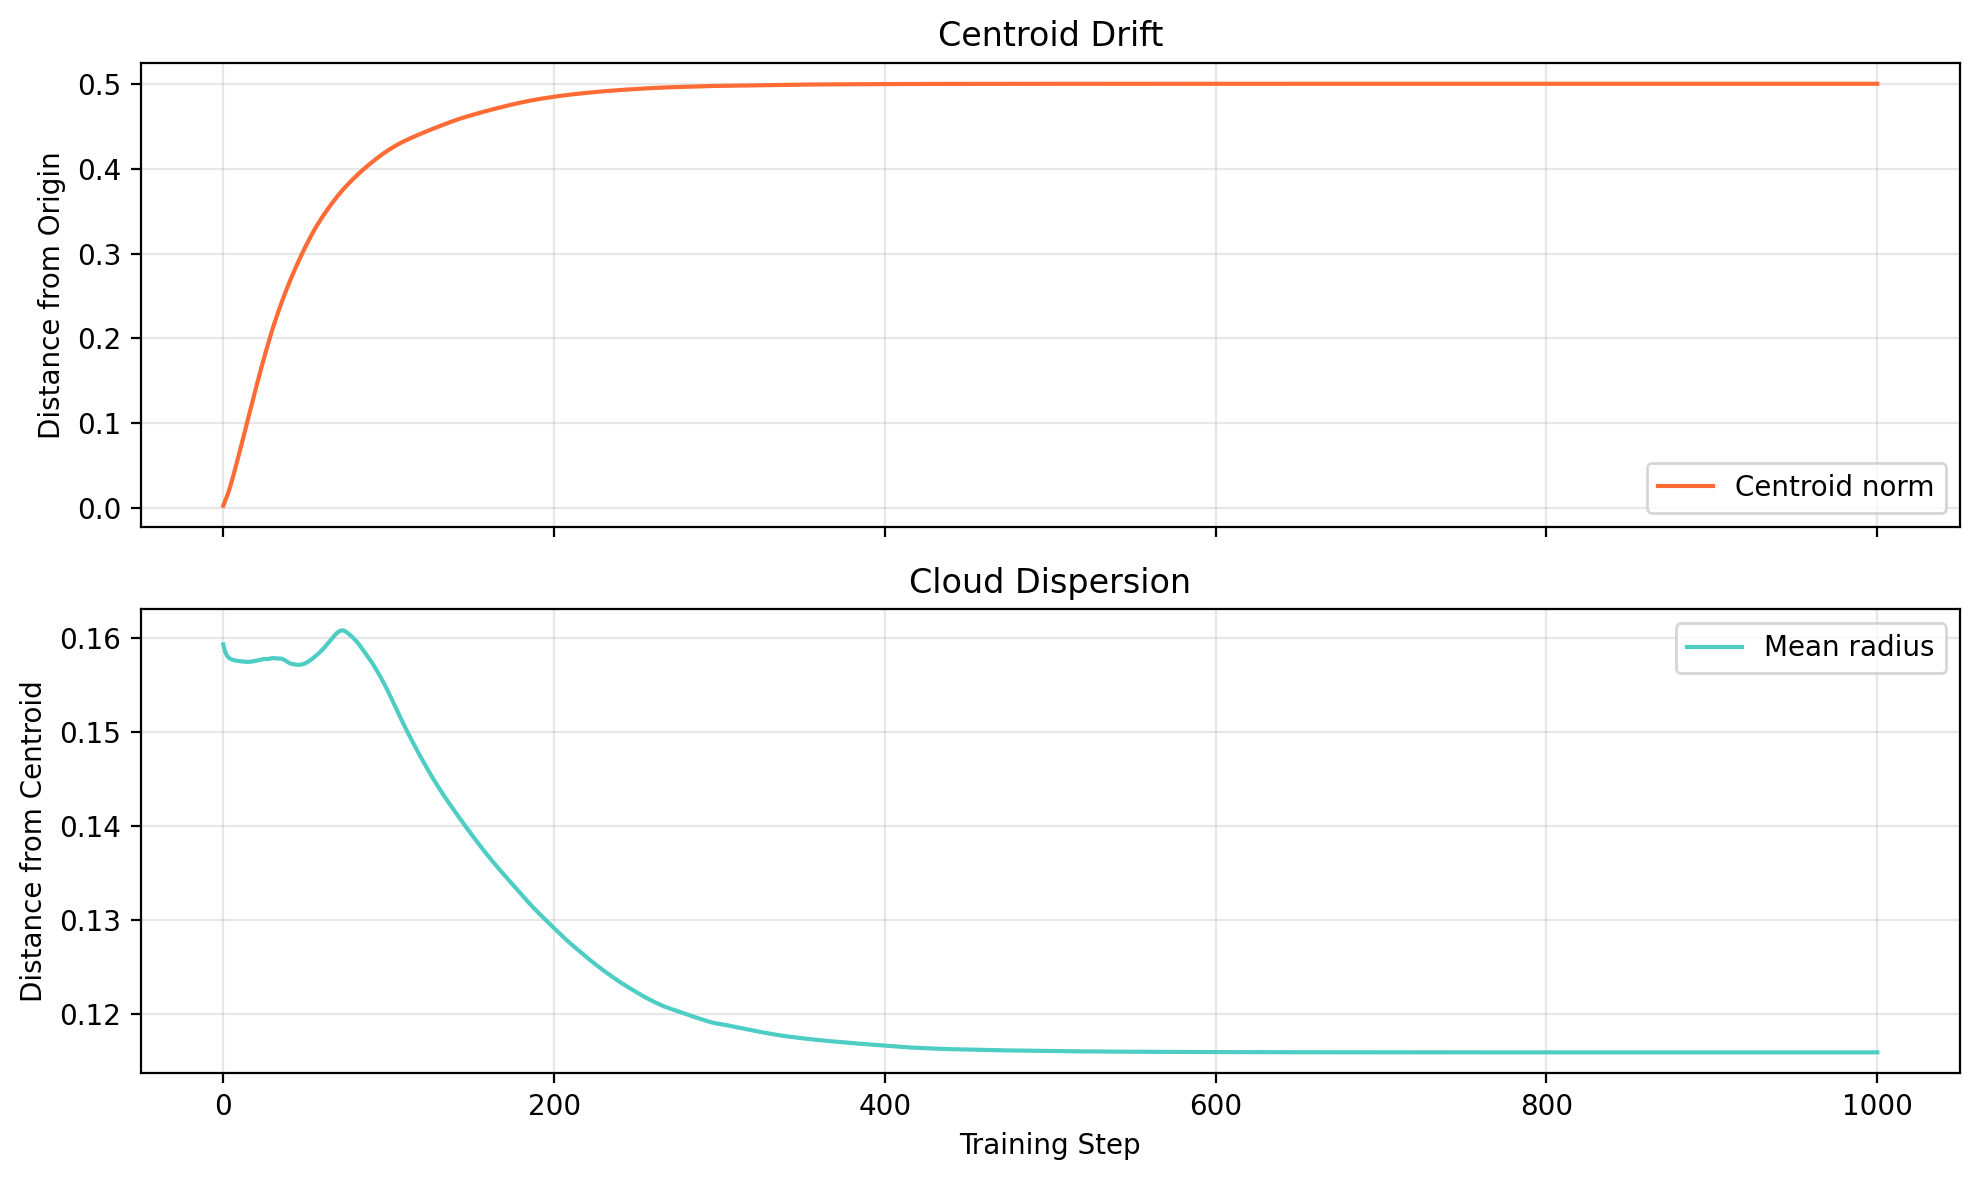

In [46]:
# Plot both on same timeline for comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), dpi=DPI, sharex=True)

# Centroid drift
ax1.plot(centroid_norms.numpy(), linewidth=1.5, color='#FF6B35', label='Centroid norm')
ax1.set_ylabel('Distance from Origin')
ax1.set_title('Centroid Drift')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Cloud dispersion
ax2.plot(dispersions.numpy(), linewidth=1.5, color='#4ECDC4', label='Mean radius')
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Distance from Centroid')
ax2.set_title('Cloud Dispersion')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

## Radial vs Directional Motion

The cloud could be:
1. **Expanding radially** (tokens moving away from origin, centroid stays near zero)
2. **Drifting directionally** (centroid moves, cloud stays compact)
3. **Both** (expanding *and* drifting)

Let's compute mean token distance from origin and compare to dispersion around centroid.

In [47]:
# Mean distance of tokens from origin (not from centroid)
mean_norms = torch.zeros(n_steps)

for t in range(n_steps):
    mean_norms[t] = torch.norm(W_dead[t], dim=1).mean()

print(f"Mean token norm at t=0: {mean_norms[0]:.6f}")
print(f"Mean token norm at t=1000: {mean_norms[-1]:.6f}")
print(f"Expansion from origin: {mean_norms[-1] / mean_norms[0]:.2f}x")

Mean token norm at t=0: 0.159323
Mean token norm at t=1000: 0.513296
Expansion from origin: 3.22x


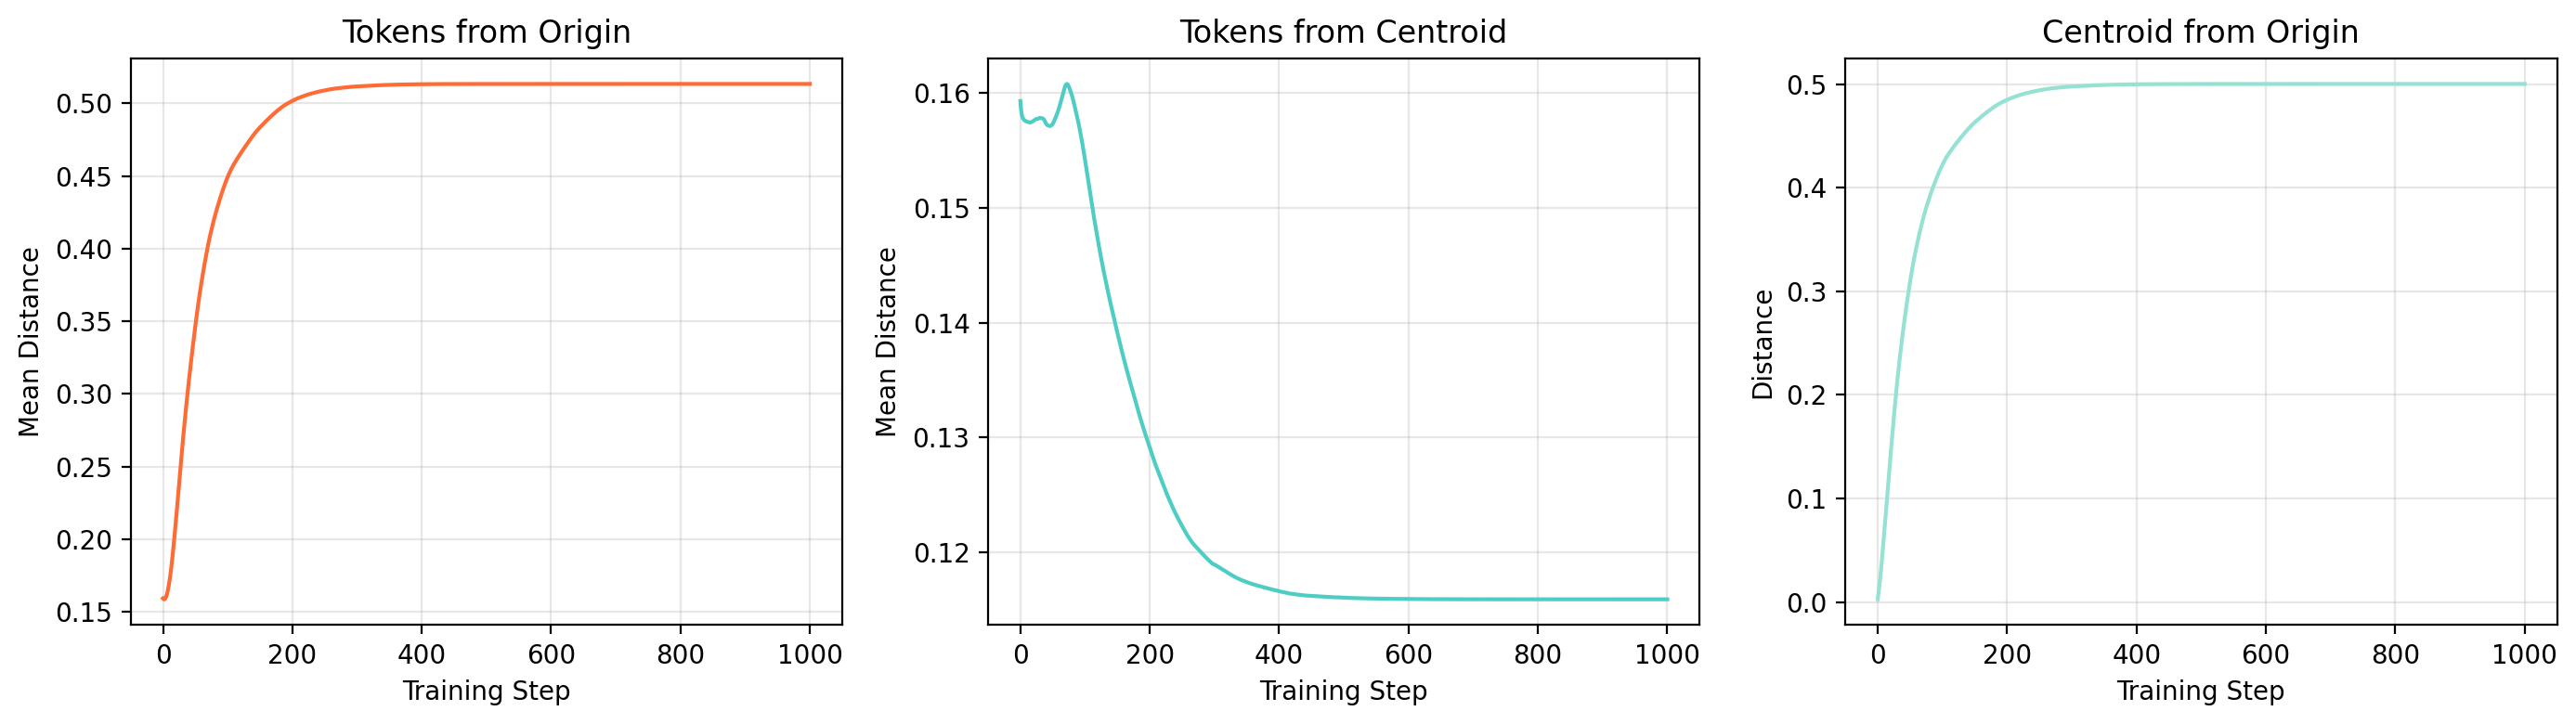

In [48]:
# Three-panel comparison
fig = plt.figure(figsize=(14, 4), dpi=DPI)
gs = GridSpec(1, 3, figure=fig)

# Panel 1: Mean distance from origin
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(mean_norms.numpy(), linewidth=1.5, color='#FF6B35')
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Mean Distance')
ax1.set_title('Tokens from Origin')
ax1.grid(True, alpha=0.3)

# Panel 2: Mean distance from centroid
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(dispersions.numpy(), linewidth=1.5, color='#4ECDC4')
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Mean Distance')
ax2.set_title('Tokens from Centroid')
ax2.grid(True, alpha=0.3)

# Panel 3: Centroid distance from origin
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(centroid_norms.numpy(), linewidth=1.5, color='#95E1D3')
ax3.set_xlabel('Training Step')
ax3.set_ylabel('Distance')
ax3.set_title('Centroid from Origin')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Velocity Analysis

Let's look at how fast things are moving.

In [49]:
# Centroid velocity (step-to-step displacement)
centroid_velocities = torch.diff(centroids, dim=0)
centroid_speeds = torch.norm(centroid_velocities, dim=1)

# Mean token velocity
token_velocities = torch.diff(W_dead, dim=0)  # (1000, 3699, 64)
token_speeds = torch.norm(token_velocities, dim=2)  # (1000, 3699)
mean_token_speed = token_speeds.mean(dim=1)  # (1000,)

print(f"Mean centroid speed: {centroid_speeds.mean():.6f}")
print(f"Mean token speed: {mean_token_speed.mean():.6f}")
print(f"Ratio (token/centroid): {mean_token_speed.mean() / centroid_speeds.mean():.2f}x")

Mean centroid speed: 0.000551
Mean token speed: 0.000608
Ratio (token/centroid): 1.10x


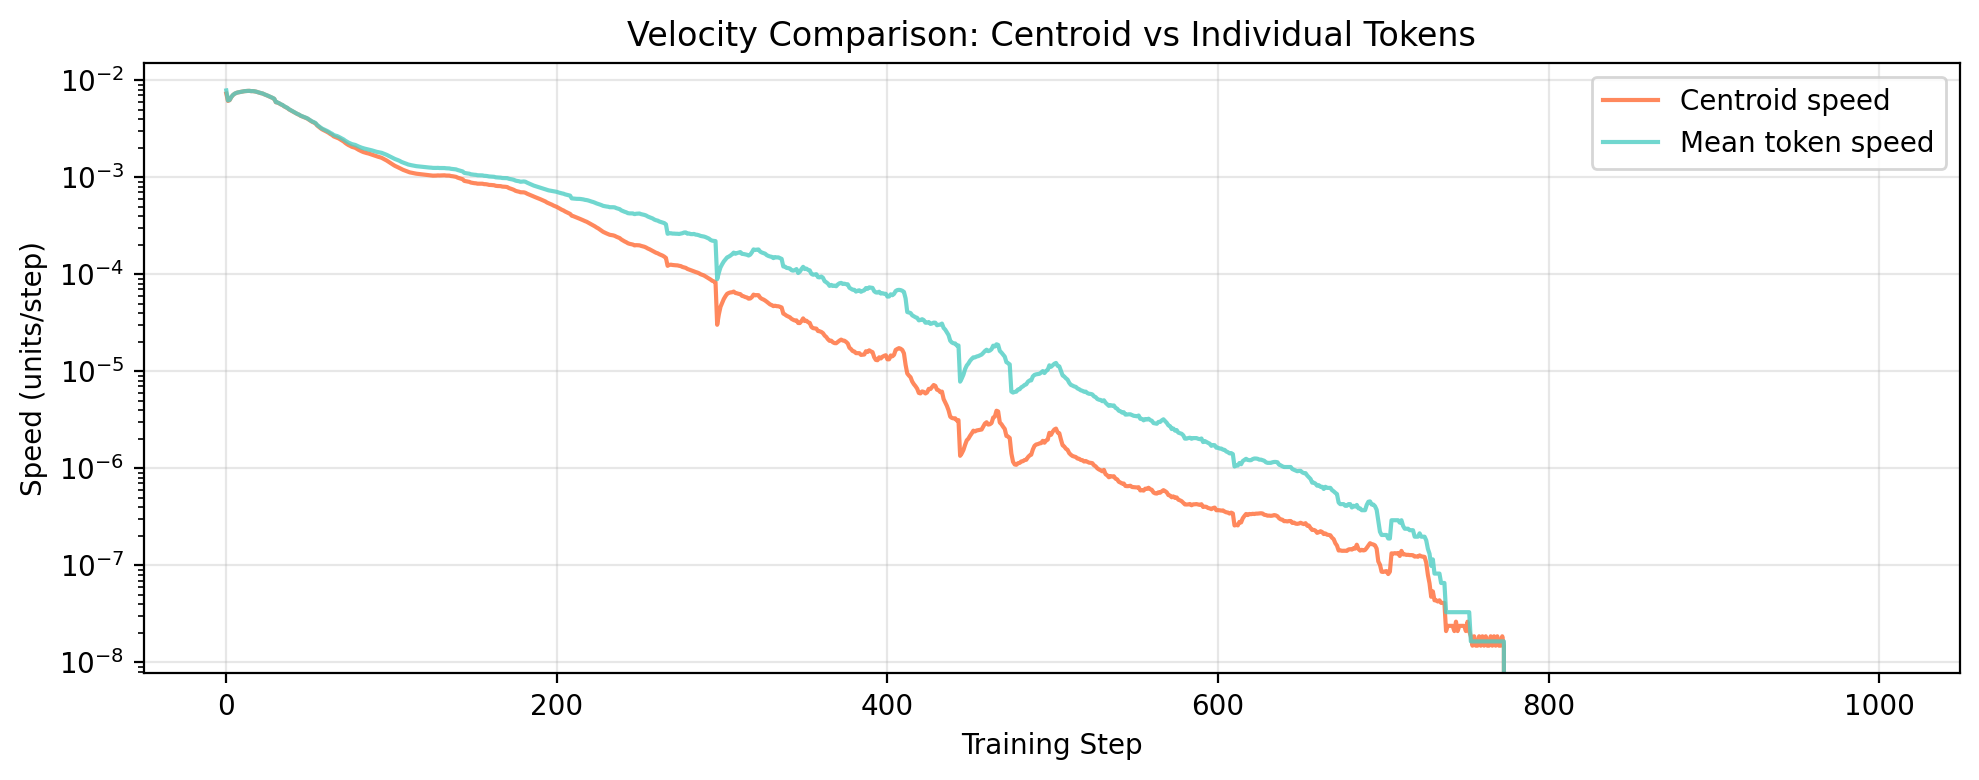

In [50]:
# Plot velocities over time
fig, ax = plt.subplots(figsize=(10, 4), dpi=DPI)

ax.plot(centroid_speeds.numpy(), linewidth=1.5, color='#FF6B35', label='Centroid speed', alpha=0.8)
ax.plot(mean_token_speed.numpy(), linewidth=1.5, color='#4ECDC4', label='Mean token speed', alpha=0.8)

ax.set_xlabel('Training Step')
ax.set_ylabel('Speed (units/step)')
ax.set_title('Velocity Comparison: Centroid vs Individual Tokens')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_yscale('log')

plt.tight_layout()
plt.show()

## Cloud Shape Evolution

Is the cloud spherical, or does it have a preferred direction?

We'll look at the eigenvalues of the covariance matrix (in the cloud's rest frame) to see if it's elongated.

In [51]:
# Sample timesteps to analyze (don't compute for all 1001 steps)
sample_times = [0, 10, 50, 100, 250, 500, 1000]

# Store eigenvalues for each sample time
eigenvalue_data = []

for t in sample_times:
    # Center cloud at origin
    centered = W_dead[t] - centroids[t]
    
    # Covariance matrix
    cov = torch.cov(centered.T)
    
    # Eigenvalues (measure of spread in principal directions)
    eigvals = torch.linalg.eigvalsh(cov)
    
    # Sort descending
    eigvals = torch.sort(eigvals, descending=True)[0]
    
    eigenvalue_data.append(eigvals.numpy())

eigenvalue_data = np.array(eigenvalue_data)  # (7, 64)

print("Cloud shape analysis complete")

Cloud shape analysis complete


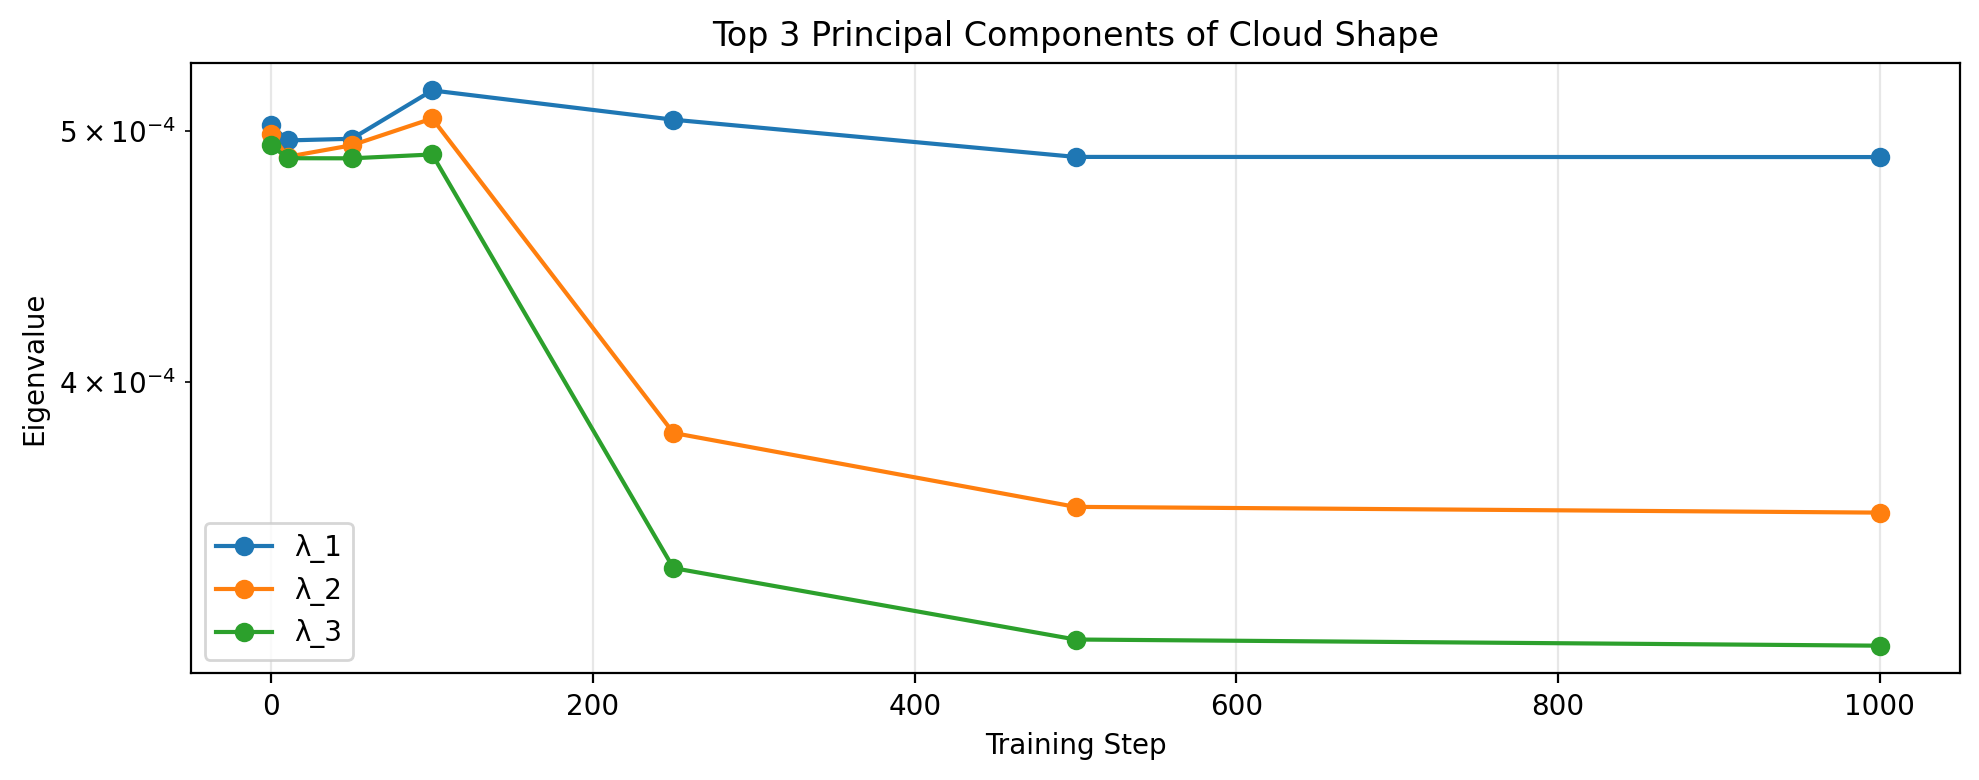

In [52]:
# Plot top 3 eigenvalues over time
fig, ax = plt.subplots(figsize=(10, 4), dpi=DPI)

for i in range(3):
    ax.plot(sample_times, eigenvalue_data[:, i], marker='o', label=f'λ_{i+1}', linewidth=1.5)

ax.set_xlabel('Training Step')
ax.set_ylabel('Eigenvalue')
ax.set_title('Top 3 Principal Components of Cloud Shape')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_yscale('log')

plt.tight_layout()
plt.show()

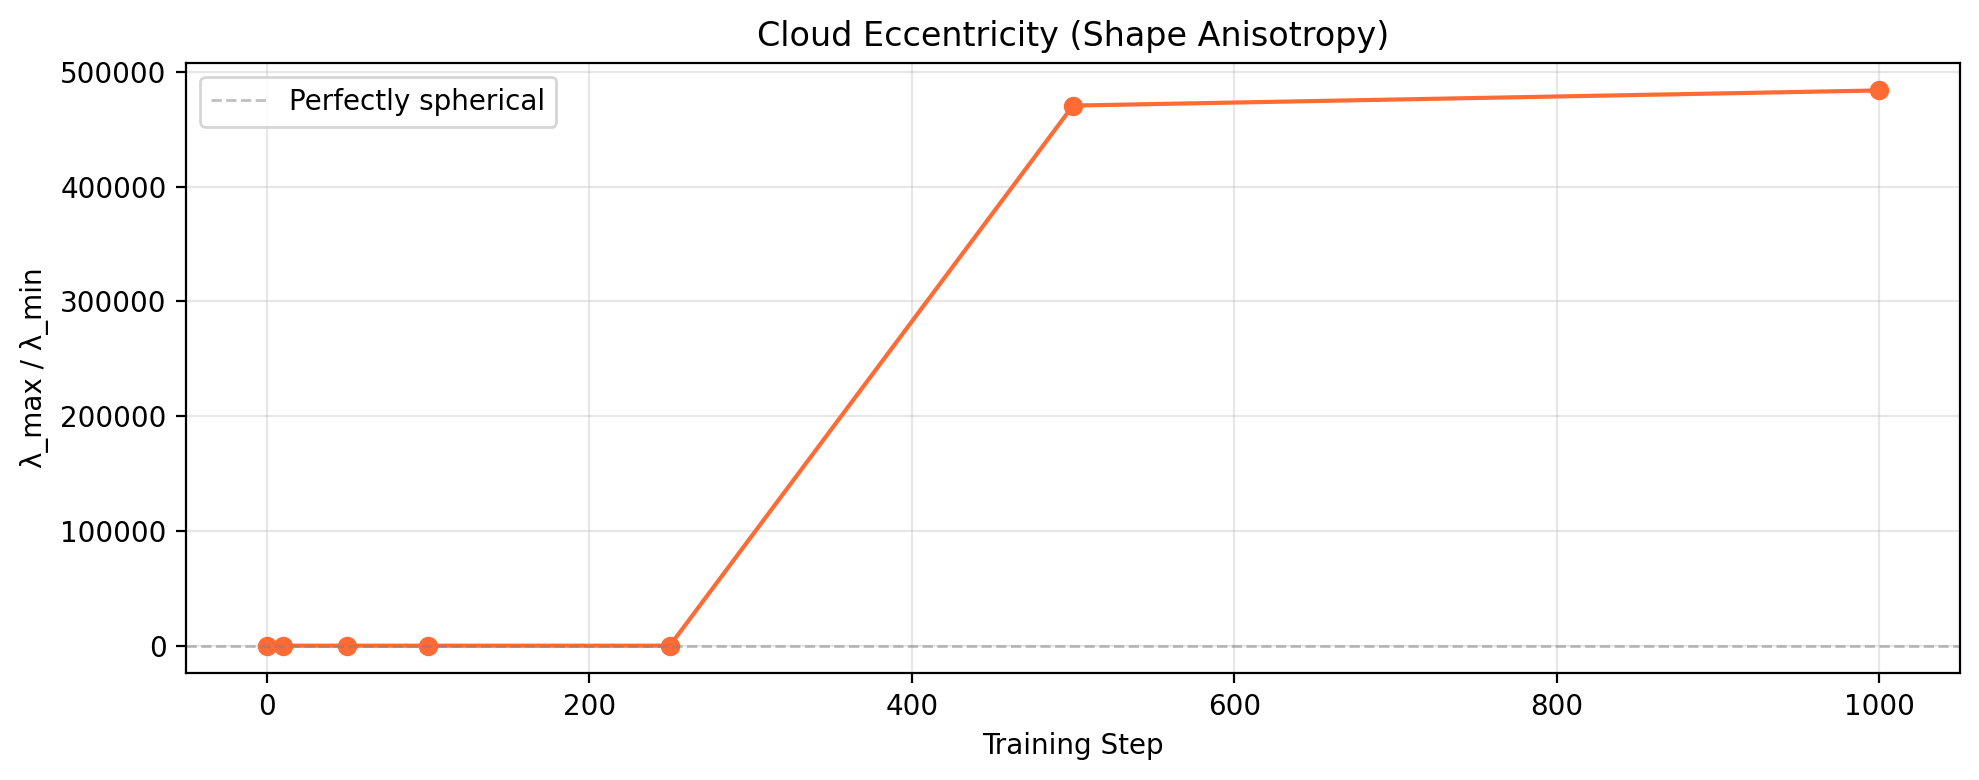


Eccentricity at t=0: 1.61
Eccentricity at t=1000: 483845.88


In [53]:
# Eccentricity: ratio of largest to smallest eigenvalue
eccentricities = eigenvalue_data[:, 0] / eigenvalue_data[:, -1]

fig, ax = plt.subplots(figsize=(10, 4), dpi=DPI)

ax.plot(sample_times, eccentricities, marker='o', linewidth=1.5, color='#FF6B35')
ax.axhline(1, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Perfectly spherical')

ax.set_xlabel('Training Step')
ax.set_ylabel('λ_max / λ_min')
ax.set_title('Cloud Eccentricity (Shape Anisotropy)')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nEccentricity at t=0: {eccentricities[0]:.2f}")
print(f"Eccentricity at t=1000: {eccentricities[-1]:.2f}")

## Summary Statistics

In [54]:
print("=" * 60)
print("DEAD TOKEN CLOUD MOTION SUMMARY")
print("=" * 60)
print()

print("CENTROID DRIFT:")
print(f"  Initial distance from origin: {centroid_norms[0]:.6f}")
print(f"  Final distance from origin:   {centroid_norms[-1]:.6f}")
print(f"  Total drift:                  {centroid_norms[-1] - centroid_norms[0]:.6f}")
print(f"  Drift / initial:              {(centroid_norms[-1] - centroid_norms[0]) / centroid_norms[0]:.2%}")
print()

print("CLOUD DISPERSION (from centroid):")
print(f"  Initial mean radius:          {dispersions[0]:.6f}")
print(f"  Final mean radius:            {dispersions[-1]:.6f}")
print(f"  Expansion factor:             {dispersions[-1] / dispersions[0]:.2f}x")
print()

print("RADIAL EXPANSION (from origin):")
print(f"  Initial mean token norm:      {mean_norms[0]:.6f}")
print(f"  Final mean token norm:        {mean_norms[-1]:.6f}")
print(f"  Expansion factor:             {mean_norms[-1] / mean_norms[0]:.2f}x")
print()

print("VELOCITY:")
print(f"  Mean centroid speed:          {centroid_speeds.mean():.6f}")
print(f"  Mean token speed:             {mean_token_speed.mean():.6f}")
print(f"  Ratio (token/centroid):       {mean_token_speed.mean() / centroid_speeds.mean():.2f}x")
print()

print("CLOUD SHAPE:")
print(f"  Initial eccentricity:         {eccentricities[0]:.2f}")
print(f"  Final eccentricity:           {eccentricities[-1]:.2f}")
print()
print("=" * 60)

DEAD TOKEN CLOUD MOTION SUMMARY

CENTROID DRIFT:
  Initial distance from origin: 0.002689
  Final distance from origin:   0.500136
  Total drift:                  0.497447
  Drift / initial:              18498.19%

CLOUD DISPERSION (from centroid):
  Initial mean radius:          0.159301
  Final mean radius:            0.115900
  Expansion factor:             0.73x

RADIAL EXPANSION (from origin):
  Initial mean token norm:      0.159323
  Final mean token norm:        0.513296
  Expansion factor:             3.22x

VELOCITY:
  Mean centroid speed:          0.000551
  Mean token speed:             0.000608
  Ratio (token/centroid):       1.10x

CLOUD SHAPE:
  Initial eccentricity:         1.61
  Final eccentricity:           483845.88

